# Pretrained CNN - Feature Extraction
In diesem Code Notebook verwenden wir für die Vorhersage von Katze und Hund ein vortrainiertes Modell. Dabei gehen wir nach dem Vorgehen der Feature Extraction. Die Codes stammen aus dem Buch von Chollet (2018).

## Loading Packages

In [1]:
import pandas as pd
import numpy as np
import os
import tensorflow as tf
from tensorflow import keras

import matplotlib
import matplotlib.pyplot as plt # plotting library
%matplotlib inline
matplotlib.get_backend()

2023-04-18 15:37:50.587526: I tensorflow/core/util/port.cc:110] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2023-04-18 15:37:50.590227: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2023-04-18 15:37:50.639941: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2023-04-18 15:37:50.642501: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F AVX512_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-04-18 15:37:51.363088: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Co

'module://matplotlib_inline.backend_inline'

## Data Path

In [2]:
# original_dataset_dir = '/Users/ystaudt/switchdrive/Bachelor_CDS/Deep_Learning/2023_Kursunterlagen/4_Convolutional_Neural_Networks/dogs-vs-cats/train'

original_dataset_dir = '../data/train'

#base_dir = '/Users/ystaudt/switchdrive/Bachelor_CDS/Deep_Learning/2023_Kursunterlagen/4_Convolutional_Neural_Networks/cats_and_dogs_small'

base_dir = '../data/cats_and_dogs_2k'

train_dir = os.path.join(base_dir, 'train')
validation_dir = os.path.join(base_dir, 'validation')
test_dir = os.path.join(base_dir, 'test')

train_cats_dir = os.path.join(train_dir, 'cats')
train_dogs_dir = os.path.join(train_dir, 'dogs')

validation_cats_dir = os.path.join(validation_dir, 'cats')
validation_dogs_dir = os.path.join(validation_dir, 'dogs')

test_cats_dir = os.path.join(test_dir, 'cats')
test_dogs_dir = os.path.join(test_dir, 'dogs')

## Data Preparation

In [3]:
datagen = tf.keras.preprocessing.image.ImageDataGenerator(rescale=1./255)
batch_size = 20

## Convolutional Base

In [4]:
conv_base = tf.keras.applications.VGG16(weights='imagenet',
                                        include_top=False,
                                        input_shape=(150,150,3))

2023-04-18 15:37:52.444450: W tensorflow/core/common_runtime/gpu/gpu_device.cc:1956] Cannot dlopen some GPU libraries. Please make sure the missing libraries mentioned above are installed properly if you would like to use GPU. Follow the guide at https://www.tensorflow.org/install/gpu for how to download and setup the required libraries for your platform.
Skipping registering GPU devices...


In [5]:
conv_base.summary()

Model: "vgg16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 150, 150, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 150, 150, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 150, 150, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 75, 75, 64)        0         
                                                                 
 block2_conv1 (Conv2D)       (None, 75, 75, 128)       73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 75, 75, 128)       147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 37, 37, 128)       0     

## Extract Feature Map

In [6]:
def extract_features(directory,sample_count):
    features = np.zeros(shape=(sample_count,4,4,512))
    labels = np.zeros(shape=sample_count)
    generator = datagen.flow_from_directory(
        directory,
        target_size=(150,150),
        batch_size = batch_size,
        class_mode='binary'
    )
    i=0
    for inputs_batch, labels_batch in generator:
        features_batch = conv_base.predict(inputs_batch)
        features[i * batch_size : (i+1) * batch_size] = features_batch
        labels[i * batch_size : (i+1) * batch_size] = labels_batch
        i += 1
        if i * batch_size >= sample_count:
            break

    return features, labels

In [7]:
train_features, train_labels = extract_features(train_dir, 2000)
validation_features, validation_labels = extract_features(validation_dir, 1000)
test_features, test_labels = extract_features(test_dir, 1000)

Found 2000 images belonging to 2 classes.
1/1 [==============================] - 0s 279ms/step
Found 1000 images belonging to 2 classes.
1/1 [==============================] - 0s 296ms/step
Found 1000 images belonging to 2 classes.
1/1 [==============================] - 0s 283ms/step


## Reshape the Tensors for Input in Dense Layers

In [8]:
train_features = np.reshape(train_features, (2000, 4*4*512))
validation_features = np.reshape(validation_features, (1000, 4*4*512))
test_featues = np.reshape(test_features, (1000, 4*4*512))

## Model building

In [9]:
model = tf.keras.models.Sequential()
model.add(tf.keras.layers.Dense(256, activation='relu', input_dim=4*4*512))
model.add(tf.keras.layers.Dropout(0,.5))
model.add(tf.keras.layers.Dense(1, activation='sigmoid'))

## Model compile

In [10]:
model.compile(loss='binary_crossentropy',
              metrics=['acc'],
              optimizer=tf.keras.optimizers.RMSprop(learning_rate=2e-5))

## Model Fit

In [11]:
history = model.fit(train_features, train_labels,
                    epochs=30,
                    batch_size=20,
                    validation_data=(validation_features, validation_labels))

Epoch 1/30
100/100 [==============================] - 2s 14ms/step - loss: 0.5191 - acc: 0.7695 - val_loss: 0.3973 - val_acc: 0.8550
Epoch 2/30
100/100 [==============================] - 1s 13ms/step - loss: 0.3461 - acc: 0.8695 - val_loss: 0.3297 - val_acc: 0.8690
Epoch 3/30
100/100 [==============================] - 1s 12ms/step - loss: 0.2847 - acc: 0.8910 - val_loss: 0.3068 - val_acc: 0.8730
Epoch 4/30
100/100 [==============================] - 1s 12ms/step - loss: 0.2489 - acc: 0.9055 - val_loss: 0.2702 - val_acc: 0.8980
Epoch 5/30
100/100 [==============================] - 1s 12ms/step - loss: 0.2264 - acc: 0.9240 - val_loss: 0.2616 - val_acc: 0.8990
Epoch 6/30
100/100 [==============================] - 1s 12ms/step - loss: 0.2059 - acc: 0.9275 - val_loss: 0.2534 - val_acc: 0.9020
Epoch 7/30
100/100 [==============================] - 1s 12ms/step - loss: 0.1880 - acc: 0.9350 - val_loss: 0.2465 - val_acc: 0.9010
Epoch 8/30
100/100 [==============================] - 1s 12ms/step - 

## Model Evaluation

In [12]:
acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(acc)+1)

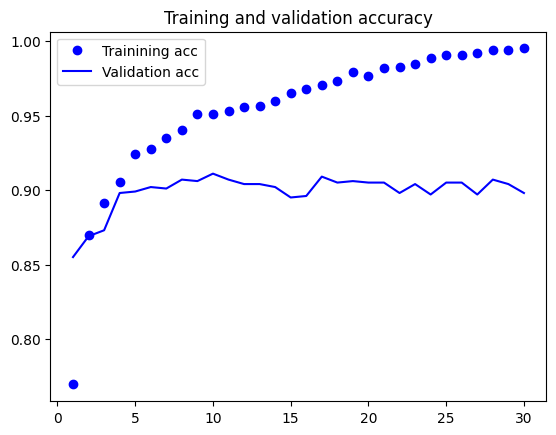

In [13]:
plt.plot(epochs, acc, 'bo', label = 'Trainining acc')
plt.plot(epochs, val_acc, 'b', label = 'Validation acc')
plt.title('Training and validation accuracy')
plt.legend()
plt.show()

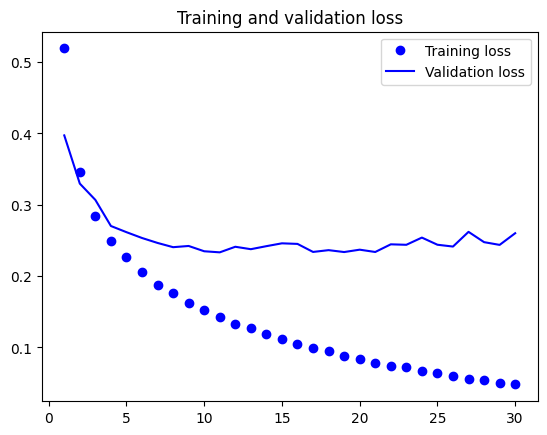

In [14]:
plt.plot(epochs, loss, 'bo', label = 'Training loss')
plt.plot(epochs, val_loss, 'b', label = 'Validation loss')
plt.title('Training and validation loss')
plt.legend()
plt.show()

## REFERENCES
Francois Chollet (2018), Deep Learning with Keras, Manning.